# Predict Pokemon type

## Parameters

In [1]:
from pathlib import Path
# Directorio del csv
BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04/pokemon')
# Directorio de las imágenes
IMAGES_DIR = BASE_DIR.joinpath('images_val')
# Nombre del csv
FILE_NAME = 'pokemon.csv'
# Se va a crear una columna con el nombre de la imagen
NAME_COL = 'Name'
# Si un pokemon tiene dos tipos, se harán dos renglones con cada clase
TYPE_COLS = ['Type1','Type2']

## Import

### Model

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
from keras.models import load_model
model = load_model(BASE_DIR.joinpath('pokemon_model.h5'))

### Indices

In [4]:
import pickle

with open(BASE_DIR.joinpath('pokemon_indices.pkl'), 'rb') as f:
    indices = pickle.load(f)

## Functions

### Real

In [5]:
import pandas as pd

def real_pokemon_type(pokemon, base_dir=BASE_DIR, file_name=FILE_NAME, name_col=NAME_COL, type_cols=TYPE_COLS):
    df = pd.read_csv(base_dir.joinpath(file_name)).set_index(name_col)
    df = df.melt(value_vars=type_cols, ignore_index=False)
    df = df.rename({'value':'type'}, axis=1).drop('variable', 1).dropna()
    try:
        type_real = df.loc[pokemon:pokemon,'type':'type']
    except:
        type_real = df.loc[pokemon,'type'].to_frame()
    return type_real

### Prediction

In [6]:
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def predict_pokemon_type(image_name, fit_model=model, class_indices=indices):
    img = Image.open(image_name)
    if str(image_name).split('.')[-1]=='.png':
        img = img.convert('RGBA')
        img.load()
        jpg = Image.new("RGB", img.size, (255, 255, 255))
        jpg.paste(img, mask=img.split()[3])
        img = jpg
    else: img = img.convert('RGB')
    img = img.resize(fit_model.layers[0].input_shape[1:3])
    img_array = np.asarray(img).astype('uint8')*1./255
    img_array = np.expand_dims(img_array, axis=0)
    prediction = fit_model.predict(img_array)
    type_predicted = pd.DataFrame(zip(class_indices,prediction[0]), columns=['type','proba'])
    type_predicted = type_predicted.sort_values('proba',ascending=False).reset_index(drop=True)
    return type_predicted.head(3).set_index('type')

### Full predict

In [7]:
def full_predict(images_dir):
    for image in images_dir.glob('*'):
        if not str(image).endswith('DS_Store'):
            pokemon_name = str(image).split('/')[-1].split('.')[0]
            pokemon_image = Image.open(image)
            display(real_pokemon_type(pokemon_name),pokemon_image)
            print('Predicted:')
            display(predict_pokemon_type(image))
            print('-'*40)

## Predict

,type
Name,
charizard,Fire
charizard,Flying


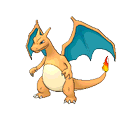

Predicted:


,proba
type,
Dragon,0.997250
Water,0.001069
Ghost,0.000496


----------------------------------------


,type
Name,
cutiefly,Bug
cutiefly,Fairy


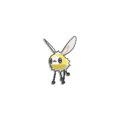

Predicted:


,proba
type,
Normal,0.137723
Water,0.098000
Psychic,0.096726


----------------------------------------


,type
Name,
rockruff,Rock


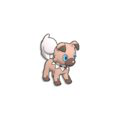

Predicted:


,proba
type,
Normal,0.145491
Flying,0.090593
Psychic,0.080418


----------------------------------------


,type
Name,
squirtle,Water


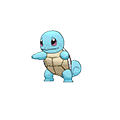

Predicted:


,proba
type,
Dragon,0.999946
Steel,0.000017
Dark,0.000017


----------------------------------------


In [9]:
full_predict(IMAGES_DIR)